In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===========================
# 📌 Preprocessing
# ===========================
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

# ===========================
# ⚖️ Class Weights
# ===========================
def compute_class_weights(y, num_classes, method='balanced'):
    if method == 'balanced':
        weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=y)
    elif method == 'inverse':
        class_counts = np.bincount(y)
        weights = 1. / (class_counts + 1e-5)
    else:
        weights = np.ones(num_classes)
    return torch.tensor(weights, dtype=torch.float32)

# ===========================
# 🔄 Dataloaders
# ===========================
def create_dataloaders(X, y, test_size=0.2, val_size=0.1, batch_size=64, random_state=42):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_size, stratify=y_train_val)

    def to_tensor_dataset(X, y):
        return TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

    return (DataLoader(to_tensor_dataset(X_train, y_train), batch_size=batch_size, shuffle=True),
            DataLoader(to_tensor_dataset(X_val, y_val), batch_size=batch_size),
            DataLoader(to_tensor_dataset(X_test, y_test), batch_size=batch_size))

# ===========================
# 🧠 MLP Model
# ===========================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], num_classes=6,
                 dropout_rates=[0.4, 0.3, 0.2], activation='relu', use_batchnorm=True):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim, dropout in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev_dim, h_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h_dim))
            layers.append({'relu': nn.ReLU(), 'leakyrelu': nn.LeakyReLU(0.1), 'gelu': nn.GELU()}[activation])
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ===========================
# 🔥 Focal Loss (optional)
# ===========================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=1)
        prob = torch.exp(log_prob)
        focal_weight = (1 - prob).pow(self.gamma)
        return F.nll_loss(focal_weight * log_prob, target, weight=self.weight, reduction=self.reduction)

# ===========================
# 🌡️ Temperature Scaling
# ===========================
def apply_temperature_scaling(logits, temperature=1.0):
    return logits / temperature

# ===========================
# 🎯 Threshold Tuning
# ===========================
def find_best_thresholds(probabilities, labels, num_classes):
    thresholds = np.linspace(0.1, 0.9, 9)
    best_thresholds = np.zeros(num_classes)
    for class_idx in range(num_classes):
        best_f1, best_thresh = 0, 0.5
        for thresh in thresholds:
            preds = (np.array(probabilities)[:, class_idx] > thresh).astype(int)
            true = (np.array(labels) == class_idx).astype(int)
            f1 = f1_score(true, preds)
            if f1 > best_f1:
                best_f1, best_thresh = f1, thresh
        best_thresholds[class_idx] = best_thresh
    return best_thresholds

# ===========================
# 📊 Metric Plots
# ===========================
def plot_per_class_metrics(all_labels, all_preds, label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(len(label_names)))
    x = range(len(label_names))
    plt.figure(figsize=(12, 5))
    width = 0.25
    plt.bar([p - width for p in x], precision, width=width, label='Precision')
    plt.bar(x, recall, width=width, label='Recall')
    plt.bar([p + width for p in x], f1, width=width, label='F1-score')
    plt.xticks(ticks=x, labels=label_names, rotation=45, ha='right')
    plt.title("Per-Class Precision, Recall, and F1-score")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===========================
# 🧾 Global F1 Scores
# ===========================
def print_f1_summary(all_labels, all_preds):
    macro = f1_score(all_labels, all_preds, average='macro')
    weighted = f1_score(all_labels, all_preds, average='weighted')
    print(f"\n🔍 Macro F1 Score: {macro:.4f}")
    print(f"🔍 Weighted F1 Score: {weighted:.4f}")
    return macro, weighted



[One-hot distribution (argmax, raw)]
OK                5703
lameness          6505
mastitis          6558
oestrus          38772
other_disease     6520
NaN                  1
Name: count, dtype: int64
[One-hot sanity] all_zero=32116, multi_hot=0, any_nan=1
[INFO] Dropped 1 rows with NaN in label columns.
[INFO] Dropped 32115 rows with all-zero labels.


Training: 100%|██████████| 200/200 [09:24<00:00,  2.82s/it]


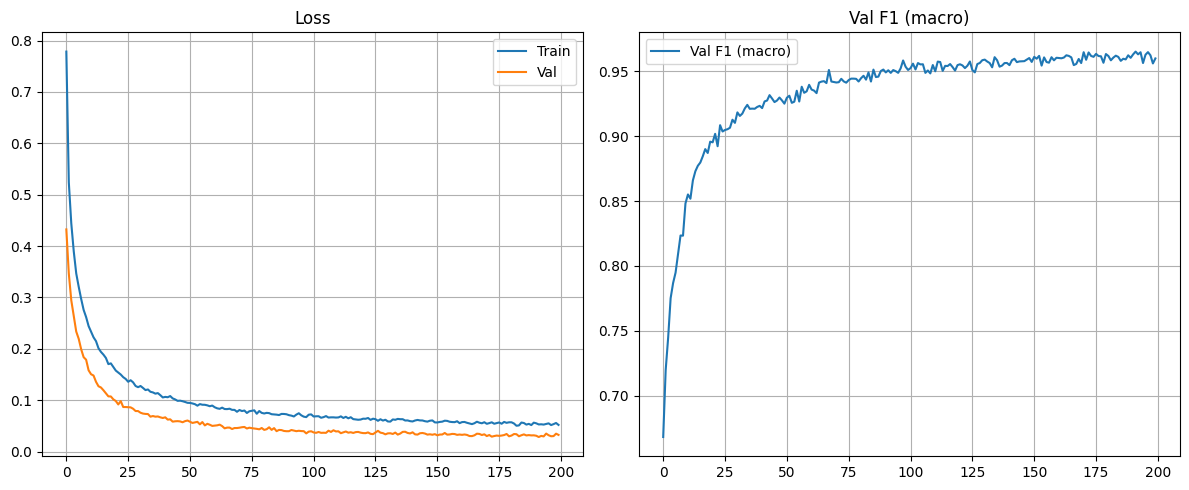

✓ Learned temperature on validation: T = 0.621

[One-hot distribution (argmax, raw)]
OK                3421
lameness          3793
mastitis          3941
oestrus          23080
other_disease     3886
Name: count, dtype: int64
[One-hot sanity] all_zero=19125, multi_hot=0, any_nan=0
[INFO] Dropped 19125 rows with all-zero labels.

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.96      1.00      0.98      3955
     lameness       0.93      1.00      0.96      3793
     mastitis       0.99      1.00      0.99      3941
other_disease       0.97      1.00      0.98      3886
           OK       1.00      0.81      0.90      3421

     accuracy                           0.97     18996
    macro avg       0.97      0.96      0.96     18996
 weighted avg       0.97      0.97      0.96     18996



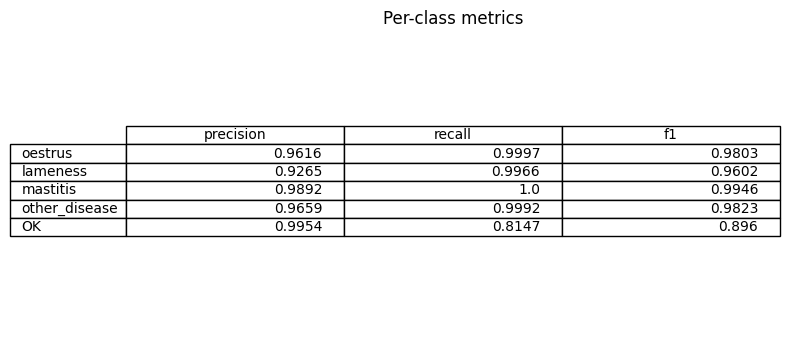

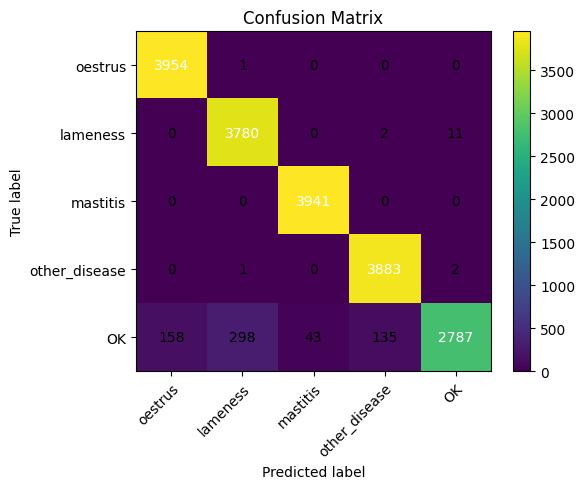


Summary:
  Accuracy      : 0.9657
  F1 (macro)    : 0.9627
  F1 (weighted) : 0.9645
Unique predicted classes on HOLDOUT: [0 1 2 3 4]


In [ ]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path("augmented_dataset2_trainval.csv")
HOLDOUT_PATH  = Path("augmented_dataset2_holdout.csv")

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','lameness','mastitis','other_disease','OK']
    else:
        label_cols = ['oestrus','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def extract_labels(df, label_cols, all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Returns:
      y (np.ndarray[int]),
      df_clean (df after cleaning according to policies),
      info (dict)
    """
    df = df.copy()
    n_classes = len(label_cols)

    # Prefer integer target if valid
    if prefer_target and _validate_target_column(df, n_classes):
        y = df['target'].astype(int).values
        return y, df, {"used": "target"}

    # Else use one-hot
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}' in dataframe.")

    bad_zero, bad_multi, bad_nan, dist = _one_hot_sanity(df, label_cols)
    print("\n[One-hot distribution (argmax, raw)]")
    print(dist)
    print(f"[One-hot sanity] all_zero={bad_zero}, multi_hot={bad_multi}, any_nan={bad_nan}")

    if bad_multi > 0:
        raise ValueError("Labels must be strictly one-hot (found multi-hot rows). Please fix source data.")

    # Handle NaNs
    if bad_nan > 0:
        if nan_policy == "error":
            raise ValueError(f"Found {bad_nan} NaN in label columns. Set NAN_POLICY='drop' to drop those rows.")
        elif nan_policy == "drop":
            before = len(df)
            mask = ~df[label_cols].isna().any(axis=1)
            df = df.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label columns.")
        else:
            raise ValueError("NAN_POLICY must be 'drop' or 'error'.")

    # Recompute after NaN drop
    bad_zero, bad_multi, bad_nan, _ = _one_hot_sanity(df, label_cols)
    assert bad_multi == 0 and bad_nan == 0, "Internal: NaN/multi-hot not resolved."

    # Handle all-zero rows
    if bad_zero > 0:
        if all_zero_policy == "error":
            raise ValueError(f"Found {bad_zero} all-zero label rows; use ALL_ZERO_POLICY='drop' or 'map_to_ok'.")
        elif all_zero_policy == "drop":
            before = len(df)
            mask = df[label_cols].sum(axis=1) > 0
            df = df.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' selected but 'OK' not in label_cols.")
            mask_zero = df[label_cols].sum(axis=1) == 0
            df.loc[mask_zero, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask_zero.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("ALL_ZERO_POLICY must be 'drop' | 'map_to_ok' | 'error'.")

    # Final check & y
    bad_zero, bad_multi, bad_nan, _ = _one_hot_sanity(df, label_cols)
    assert bad_zero == 0 and bad_multi == 0 and bad_nan == 0, "Internal: labels still invalid after cleaning."
    y = df[label_cols].astype(float).values.argmax(axis=1)
    return y, df, {"used": "one_hot"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','duration_hours']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )


[INFO] Dropped 1 rows with NaN in label block after coercion.


Training: 100%|██████████| 200/200 [05:45<00:00,  1.73s/it]


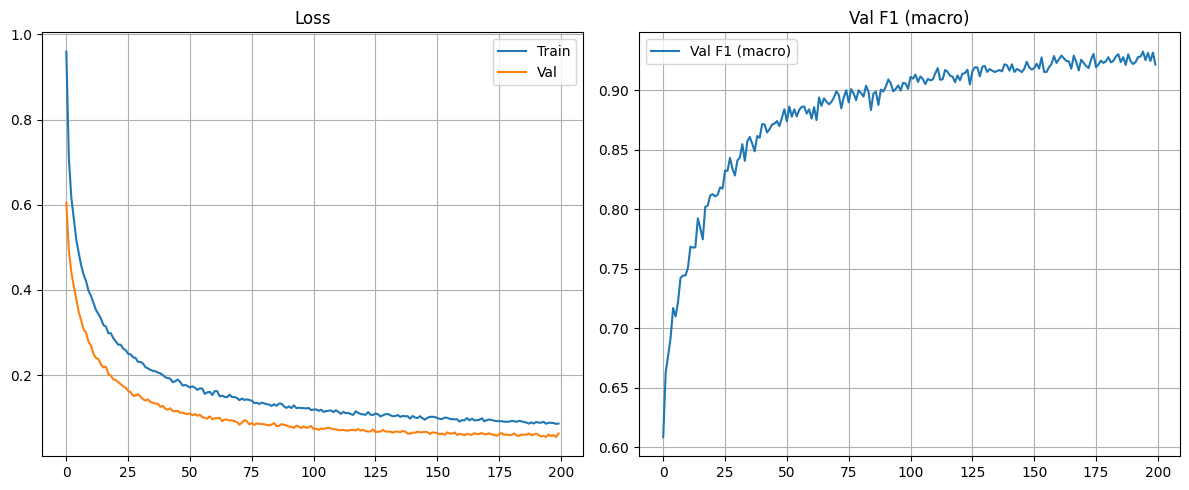

✓ Learned temperature on validation: T = 0.653

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.84      0.99      0.91      1745
      calving       0.97      1.00      0.99      1726
     lameness       0.89      1.00      0.94      1748
     mastitis       0.98      1.00      0.99      1743
other_disease       0.96      1.00      0.98      1754
           OK       0.99      0.60      0.75      1743

     accuracy                           0.93     10459
    macro avg       0.94      0.93      0.93     10459
 weighted avg       0.94      0.93      0.93     10459



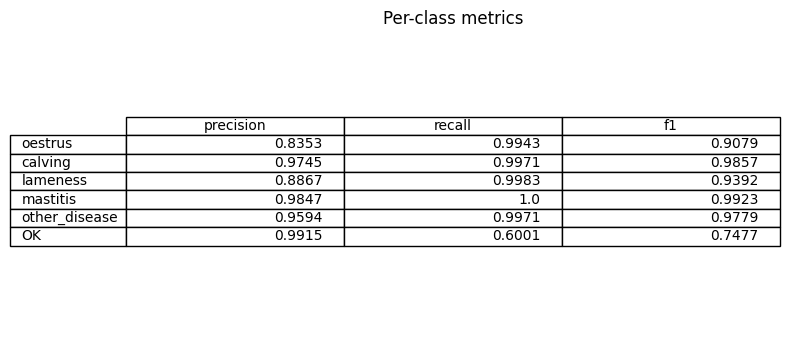

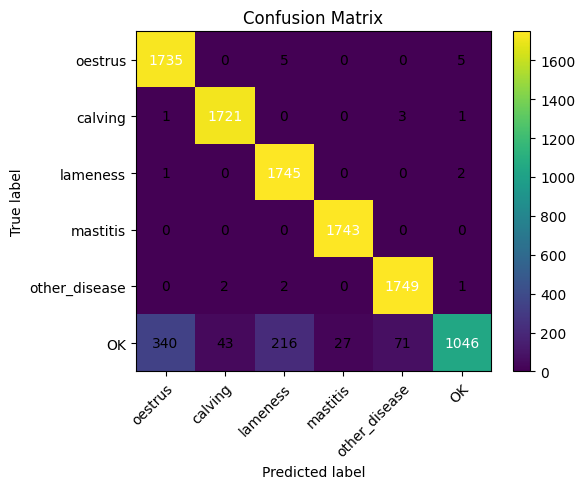


Summary:
  Accuracy      : 0.9312
  F1 (macro)    : 0.9251
  F1 (weighted) : 0.9251
Unique predicted classes on HOLDOUT: [0 1 2 3 4 5]


In [2]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path("augmented_dataset4_trainval.csv")
HOLDOUT_PATH  = Path("augmented_dataset4_holdout.csv")

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    else:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def coerce_one_hot_numeric(df, label_cols):
    """
    Try to coerce a possibly stringy 'one-hot' block into numeric 0/1.
    Rules per cell:
      - numeric -> kept (0/1 expected, but any number allowed until sanity check)
      - string equal to its column name (case-insensitive, trimmed) -> 1
      - '1','true','yes' -> 1
      - '0','false','no','' (empty) -> 0
      - otherwise -> NaN (so NaN policy can handle)
    """
    sub = df[label_cols].copy()

    # Fast path: already numeric
    if np.all(sub.dtypes.apply(lambda t: np.issubdtype(t, np.number))):
        return sub.astype(float)

    def to01(col_series, col_name):
        s = col_series.astype(str).str.strip()
        lower = s.str.lower()

        is_colname = lower == col_name.lower()
        is_one  = lower.isin(["1", "true", "yes", "y"])
        is_zero = lower.isin(["0", "false", "no", "n", "nan", "none", ""])

        out = pd.Series(np.nan, index=s.index, dtype=float)
        out[is_colname | is_one] = 1.0
        out[is_zero]             = 0.0

        # If original dtype was numeric for some rows, preserve those values
        # (helps when a column is mixed types)
        mask_numeric = pd.to_numeric(col_series, errors="coerce").notna()
        out.loc[mask_numeric] = pd.to_numeric(col_series.loc[mask_numeric], errors="coerce")

        return out

    coerced = pd.DataFrame(index=sub.index, columns=label_cols, dtype=float)
    for c in label_cols:
        coerced[c] = to01(sub[c], c)

    return coerced


def extract_labels(df, label_cols, class_order=None,
                   all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Supports:
      - Single label column (class names or ints)  --> map to ids
      - Multi-column one-hot (numeric or stringy)  --> coerce to numeric then argmax
      - Optional integer 'target' (0..C-1) if prefer_target=True
    """
    df = df.copy()

    # Single label column mode
    if len(label_cols) == 1:
        col = label_cols[0]
        if prefer_target and 'target' in df.columns:
            vals = df['target']
            if vals.notna().all() and np.equal(vals, np.floor(vals)).all():
                vals = vals.astype(int)
                if class_order is None or (0 <= vals.min() and vals.max() < len(class_order)):
                    return vals.values, df, {"used": "target_single"}

        lab = df[col]
        if nan_policy == "drop" and lab.isna().any():
            before = len(df); df = df[lab.notna()].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in '{col}'.")
            lab = df[col]
        elif lab.isna().any():
            raise ValueError(f"NaN found in '{col}'. Set NAN_POLICY='drop' to drop them.")

        # Map strings to ids using provided class_order
        if lab.dtype == object or isinstance(lab.iloc[0], str):
            assert class_order is not None, "Provide class_order to map string labels to ids."
            name2idx = {n: i for i, n in enumerate(class_order)}
            y = lab.astype(str).str.strip().map(name2idx)
            if y.isna().any():
                unknown = df.loc[y.isna(), col].unique()
                raise ValueError(f"Unknown label names: {unknown}. Update class_order or clean data.")
            return y.values.astype(int), df, {"used": "single_str"}
        else:
            return lab.astype(int).values, df, {"used": "single_int"}

    # Multi-column one-hot mode
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}'.")

    # Prefer integer target if valid
    if prefer_target and 'target' in df.columns:
        col = df['target']
        if col.notna().all() and np.equal(col, np.floor(col)).all():
            vals = col.astype(int)
            if 0 <= vals.min() and vals.max() < len(label_cols):
                return vals.values, df, {"used": "target_onehot"}

    # Coerce to numeric 0/1 if needed
    sub = coerce_one_hot_numeric(df, label_cols)

    # Handle NaNs
    if sub.isna().any(axis=1).any():
        if nan_policy == "drop":
            before = len(df)
            mask = ~sub.isna().any(axis=1)
            df  = df.loc[mask].copy()
            sub = sub.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label block after coercion.")
        else:
            raise ValueError("NaN in label columns after coercion. Set NAN_POLICY='drop'.")

    # One-hot sanity
    row_sums = sub.sum(axis=1).values
    bad_multi = int((row_sums > 1.0 + 1e-9).sum())
    bad_zero  = int((row_sums == 0).sum())

    if bad_multi > 0:
        raise ValueError("Found multi-hot rows; labels must be strictly one-hot.")

    if bad_zero > 0:
        if all_zero_policy == "drop":
            before = len(df)
            keep = row_sums > 0
            df  = df.loc[keep].copy()
            sub = sub.loc[keep].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' chosen but 'OK' not in label_cols.")
            mask0 = (row_sums == 0)
            sub.loc[mask0, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask0.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("All-zero labels; set ALL_ZERO_POLICY='drop' or 'map_to_ok'.")

    y = sub.values.argmax(axis=1)
    return y, df, {"used": "one_hot_coerced"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','duration_hours']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )


Training:  79%|███████▉  | 158/200 [23:13<06:10,  8.82s/it]


Early stopping at epoch 159


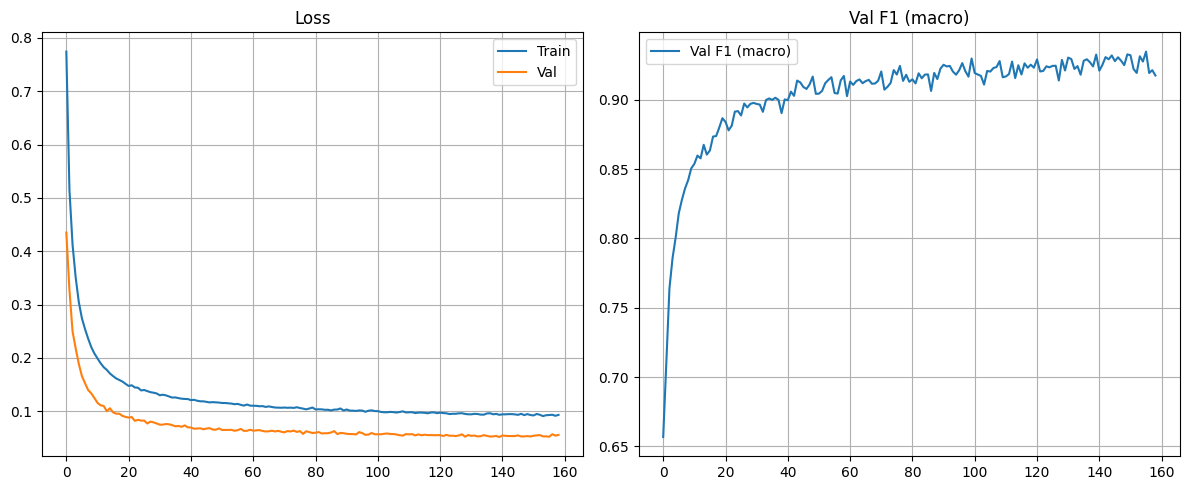

✓ Learned temperature on validation: T = 0.608

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.76      0.98      0.86      2000
      calving       0.99      1.00      0.99      2072
     lameness       0.97      1.00      0.99      2072
     mastitis       0.97      1.00      0.99      2071
other_disease       0.96      1.00      0.98      2063
           OK       0.97      0.55      0.70      1782

     accuracy                           0.93     12060
    macro avg       0.94      0.92      0.92     12060
 weighted avg       0.94      0.93      0.92     12060



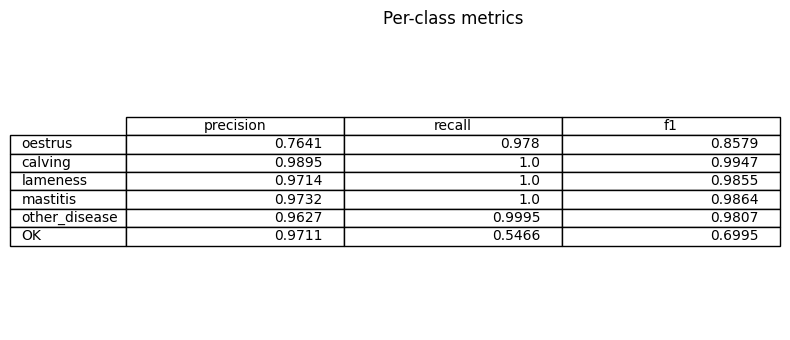

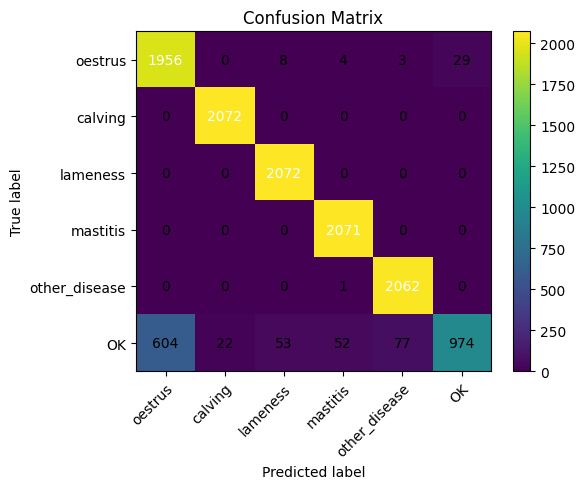


Summary:
  Accuracy      : 0.9293
  F1 (macro)    : 0.9175
  F1 (weighted) : 0.9230
Unique predicted classes on HOLDOUT: [0 1 2 3 4 5]


In [2]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path("augmented_dataset1_trainval.csv")
HOLDOUT_PATH  = Path("augmented_dataset1_holdout.csv")

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    else:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def coerce_one_hot_numeric(df, label_cols):
    """
    Try to coerce a possibly stringy 'one-hot' block into numeric 0/1.
    Rules per cell:
      - numeric -> kept (0/1 expected, but any number allowed until sanity check)
      - string equal to its column name (case-insensitive, trimmed) -> 1
      - '1','true','yes' -> 1
      - '0','false','no','' (empty) -> 0
      - otherwise -> NaN (so NaN policy can handle)
    """
    sub = df[label_cols].copy()

    # Fast path: already numeric
    if np.all(sub.dtypes.apply(lambda t: np.issubdtype(t, np.number))):
        return sub.astype(float)

    def to01(col_series, col_name):
        s = col_series.astype(str).str.strip()
        lower = s.str.lower()

        is_colname = lower == col_name.lower()
        is_one  = lower.isin(["1", "true", "yes", "y"])
        is_zero = lower.isin(["0", "false", "no", "n", "nan", "none", ""])

        out = pd.Series(np.nan, index=s.index, dtype=float)
        out[is_colname | is_one] = 1.0
        out[is_zero]             = 0.0

        # If original dtype was numeric for some rows, preserve those values
        # (helps when a column is mixed types)
        mask_numeric = pd.to_numeric(col_series, errors="coerce").notna()
        out.loc[mask_numeric] = pd.to_numeric(col_series.loc[mask_numeric], errors="coerce")

        return out

    coerced = pd.DataFrame(index=sub.index, columns=label_cols, dtype=float)
    for c in label_cols:
        coerced[c] = to01(sub[c], c)

    return coerced


def extract_labels(df, label_cols, class_order=None,
                   all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Supports:
      - Single label column (class names or ints)  --> map to ids
      - Multi-column one-hot (numeric or stringy)  --> coerce to numeric then argmax
      - Optional integer 'target' (0..C-1) if prefer_target=True
    """
    df = df.copy()

    # Single label column mode
    if len(label_cols) == 1:
        col = label_cols[0]
        if prefer_target and 'target' in df.columns:
            vals = df['target']
            if vals.notna().all() and np.equal(vals, np.floor(vals)).all():
                vals = vals.astype(int)
                if class_order is None or (0 <= vals.min() and vals.max() < len(class_order)):
                    return vals.values, df, {"used": "target_single"}

        lab = df[col]
        if nan_policy == "drop" and lab.isna().any():
            before = len(df); df = df[lab.notna()].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in '{col}'.")
            lab = df[col]
        elif lab.isna().any():
            raise ValueError(f"NaN found in '{col}'. Set NAN_POLICY='drop' to drop them.")

        # Map strings to ids using provided class_order
        if lab.dtype == object or isinstance(lab.iloc[0], str):
            assert class_order is not None, "Provide class_order to map string labels to ids."
            name2idx = {n: i for i, n in enumerate(class_order)}
            y = lab.astype(str).str.strip().map(name2idx)
            if y.isna().any():
                unknown = df.loc[y.isna(), col].unique()
                raise ValueError(f"Unknown label names: {unknown}. Update class_order or clean data.")
            return y.values.astype(int), df, {"used": "single_str"}
        else:
            return lab.astype(int).values, df, {"used": "single_int"}

    # Multi-column one-hot mode
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}'.")

    # Prefer integer target if valid
    if prefer_target and 'target' in df.columns:
        col = df['target']
        if col.notna().all() and np.equal(col, np.floor(col)).all():
            vals = col.astype(int)
            if 0 <= vals.min() and vals.max() < len(label_cols):
                return vals.values, df, {"used": "target_onehot"}

    # Coerce to numeric 0/1 if needed
    sub = coerce_one_hot_numeric(df, label_cols)

    # Handle NaNs
    if sub.isna().any(axis=1).any():
        if nan_policy == "drop":
            before = len(df)
            mask = ~sub.isna().any(axis=1)
            df  = df.loc[mask].copy()
            sub = sub.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label block after coercion.")
        else:
            raise ValueError("NaN in label columns after coercion. Set NAN_POLICY='drop'.")

    # One-hot sanity
    row_sums = sub.sum(axis=1).values
    bad_multi = int((row_sums > 1.0 + 1e-9).sum())
    bad_zero  = int((row_sums == 0).sum())

    if bad_multi > 0:
        raise ValueError("Found multi-hot rows; labels must be strictly one-hot.")

    if bad_zero > 0:
        if all_zero_policy == "drop":
            before = len(df)
            keep = row_sums > 0
            df  = df.loc[keep].copy()
            sub = sub.loc[keep].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' chosen but 'OK' not in label_cols.")
            mask0 = (row_sums == 0)
            sub.loc[mask0, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask0.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("All-zero labels; set ALL_ZERO_POLICY='drop' or 'map_to_ok'.")

    y = sub.values.argmax(axis=1)
    return y, df, {"used": "one_hot_coerced"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','duration_hours']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )


Training:  93%|█████████▎| 186/200 [23:58<01:48,  7.73s/it]


Early stopping at epoch 187


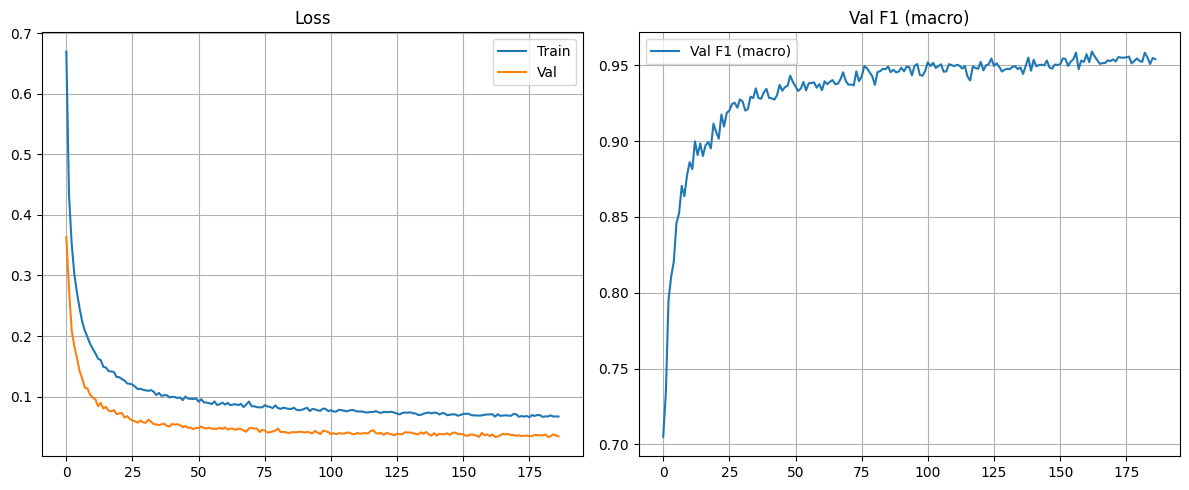

✓ Learned temperature on validation: T = 0.579

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.90      1.00      0.95      1745
      calving       0.98      1.00      0.99      1726
     lameness       0.94      1.00      0.97      1748
     mastitis       0.99      1.00      0.99      1743
other_disease       0.97      1.00      0.99      1754
           OK       1.00      0.76      0.86      1743

     accuracy                           0.96     10459
    macro avg       0.96      0.96      0.96     10459
 weighted avg       0.96      0.96      0.96     10459



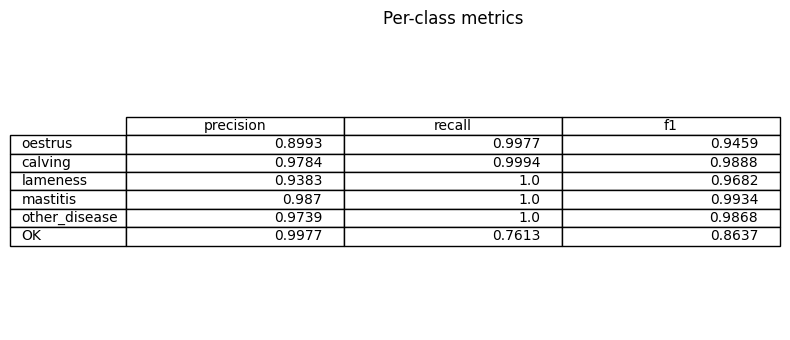

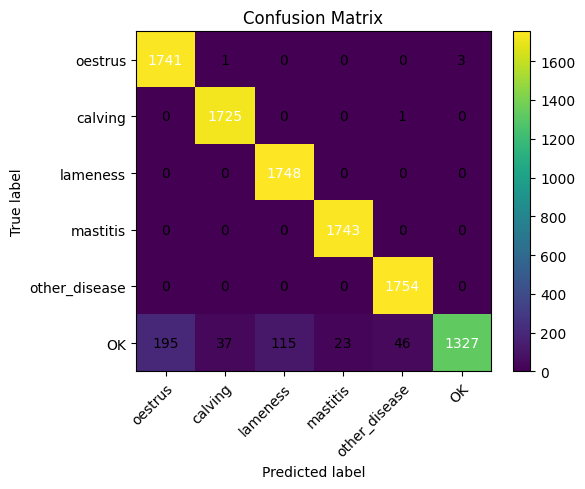


Summary:
  Accuracy      : 0.9597
  F1 (macro)    : 0.9578
  F1 (weighted) : 0.9578
Unique predicted classes on HOLDOUT: [0 1 2 3 4 5]


In [3]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path("augmented_dataset4_trainval.csv")
HOLDOUT_PATH  = Path("augmented_dataset4_holdout.csv")

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    else:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def coerce_one_hot_numeric(df, label_cols):
    """
    Try to coerce a possibly stringy 'one-hot' block into numeric 0/1.
    Rules per cell:
      - numeric -> kept (0/1 expected, but any number allowed until sanity check)
      - string equal to its column name (case-insensitive, trimmed) -> 1
      - '1','true','yes' -> 1
      - '0','false','no','' (empty) -> 0
      - otherwise -> NaN (so NaN policy can handle)
    """
    sub = df[label_cols].copy()

    # Fast path: already numeric
    if np.all(sub.dtypes.apply(lambda t: np.issubdtype(t, np.number))):
        return sub.astype(float)

    def to01(col_series, col_name):
        s = col_series.astype(str).str.strip()
        lower = s.str.lower()

        is_colname = lower == col_name.lower()
        is_one  = lower.isin(["1", "true", "yes", "y"])
        is_zero = lower.isin(["0", "false", "no", "n", "nan", "none", ""])

        out = pd.Series(np.nan, index=s.index, dtype=float)
        out[is_colname | is_one] = 1.0
        out[is_zero]             = 0.0

        # If original dtype was numeric for some rows, preserve those values
        # (helps when a column is mixed types)
        mask_numeric = pd.to_numeric(col_series, errors="coerce").notna()
        out.loc[mask_numeric] = pd.to_numeric(col_series.loc[mask_numeric], errors="coerce")

        return out

    coerced = pd.DataFrame(index=sub.index, columns=label_cols, dtype=float)
    for c in label_cols:
        coerced[c] = to01(sub[c], c)

    return coerced


def extract_labels(df, label_cols, class_order=None,
                   all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Supports:
      - Single label column (class names or ints)  --> map to ids
      - Multi-column one-hot (numeric or stringy)  --> coerce to numeric then argmax
      - Optional integer 'target' (0..C-1) if prefer_target=True
    """
    df = df.copy()

    # Single label column mode
    if len(label_cols) == 1:
        col = label_cols[0]
        if prefer_target and 'target' in df.columns:
            vals = df['target']
            if vals.notna().all() and np.equal(vals, np.floor(vals)).all():
                vals = vals.astype(int)
                if class_order is None or (0 <= vals.min() and vals.max() < len(class_order)):
                    return vals.values, df, {"used": "target_single"}

        lab = df[col]
        if nan_policy == "drop" and lab.isna().any():
            before = len(df); df = df[lab.notna()].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in '{col}'.")
            lab = df[col]
        elif lab.isna().any():
            raise ValueError(f"NaN found in '{col}'. Set NAN_POLICY='drop' to drop them.")

        # Map strings to ids using provided class_order
        if lab.dtype == object or isinstance(lab.iloc[0], str):
            assert class_order is not None, "Provide class_order to map string labels to ids."
            name2idx = {n: i for i, n in enumerate(class_order)}
            y = lab.astype(str).str.strip().map(name2idx)
            if y.isna().any():
                unknown = df.loc[y.isna(), col].unique()
                raise ValueError(f"Unknown label names: {unknown}. Update class_order or clean data.")
            return y.values.astype(int), df, {"used": "single_str"}
        else:
            return lab.astype(int).values, df, {"used": "single_int"}

    # Multi-column one-hot mode
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}'.")

    # Prefer integer target if valid
    if prefer_target and 'target' in df.columns:
        col = df['target']
        if col.notna().all() and np.equal(col, np.floor(col)).all():
            vals = col.astype(int)
            if 0 <= vals.min() and vals.max() < len(label_cols):
                return vals.values, df, {"used": "target_onehot"}

    # Coerce to numeric 0/1 if needed
    sub = coerce_one_hot_numeric(df, label_cols)

    # Handle NaNs
    if sub.isna().any(axis=1).any():
        if nan_policy == "drop":
            before = len(df)
            mask = ~sub.isna().any(axis=1)
            df  = df.loc[mask].copy()
            sub = sub.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label block after coercion.")
        else:
            raise ValueError("NaN in label columns after coercion. Set NAN_POLICY='drop'.")

    # One-hot sanity
    row_sums = sub.sum(axis=1).values
    bad_multi = int((row_sums > 1.0 + 1e-9).sum())
    bad_zero  = int((row_sums == 0).sum())

    if bad_multi > 0:
        raise ValueError("Found multi-hot rows; labels must be strictly one-hot.")

    if bad_zero > 0:
        if all_zero_policy == "drop":
            before = len(df)
            keep = row_sums > 0
            df  = df.loc[keep].copy()
            sub = sub.loc[keep].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' chosen but 'OK' not in label_cols.")
            mask0 = (row_sums == 0)
            sub.loc[mask0, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask0.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("All-zero labels; set ALL_ZERO_POLICY='drop' or 'map_to_ok'.")

    y = sub.values.argmax(axis=1)
    return y, df, {"used": "one_hot_coerced"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','duration_hours']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )
